In [1]:
import os
import shutil
from collections import defaultdict
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlp

FONTDICT = {
    'family': 'serif', 
    'color': 'black', 
    'weight': 'normal', 
    'size': 12
}

In [2]:
def get_results(dataset, models):

    valid_models = set(models)
    results = defaultdict(list)

    for model in valid_models.copy():

        exp_dir = f'./results/{dataset}/{model}'
        for run in os.listdir(exp_dir):
            run_dir = f'{exp_dir}/{run}'
            if os.path.isdir(run_dir):
                results[model].append(dict())
                for split in ('training', 'validation', 'testing'):
                    fn = f'{run_dir}/{split}_results.pkl'
                    if os.path.isfile(fn):
                        with open(fn, 'rb') as f:
                            results[model][-1][split] = dict(pickle.load(f))
                if not results[model][-1]:
                    results[model].pop()
    
    return dict(results), tuple(valid_models)

def loss(data, idxs, jump):
    ys = list()
    for idx in idxs:
        loss = sum(data['loss'][idx-jump:idx])
        tp, tn, fp, fn = (
            sum(data['tp'][idx-jump:idx]),
            sum(data['tn'][idx-jump:idx]),
            sum(data['fp'][idx-jump:idx]),
            sum(data['fn'][idx-jump:idx]),
        )
        ys.append(loss / (tp+tn+fp+fn))
    return ys

def accuracy(data, idxs, jump):
    ys = list()
    for idx in idxs:
        tp, tn, fp, fn = (
            sum(data['tp'][idx-jump:idx]),
            sum(data['tn'][idx-jump:idx]),
            sum(data['fp'][idx-jump:idx]),
            sum(data['fn'][idx-jump:idx]),
        )
        acc = (tp+tn) / (tp+tn+fp+fn)
        ys.append(acc)
    return ys

def f1_score(data, idxs, jump):
    ys = list()
    for idx in idxs:
        tp, fp, fn = (
            sum(data['tp'][idx-jump:idx]),
            sum(data['fp'][idx-jump:idx]),
            sum(data['fn'][idx-jump:idx]),
        )
        f1 = (tp+tp) / (tp+tp+fp+fn)
        ys.append(f1)
    return ys

fn_map = {
    'Loss': loss,
    'Accuracy': accuracy,
    'F1-Score': f1_score
}

models = ['ALBERT', 'BERT', 'BERTweet', 'CT-BERT', 'DistilBERT', 'Longformer', 'RoBERTa', 'Twitter-RoBERTa', 'XLM', 'XLM-RoBERTa', 'XLNet',]
pairs = (
    ('CT-BERT', 'Twitter-RoBERTa'), 
    ('CT-BERT-NT', 'Twitter-RoBERTa-NT'), 
    ('CT-BERT', 'CT-BERT-NT'), 
    ('Twitter-RoBERTa', 'Twitter-RoBERTa-NT'),
)

In [10]:
datasets = (
    'aaai-constraint-covid',
    'aaai-constraint-covid-appended',
)

index = sorted(models)
metric = 'Accuracy'
jump = 1

# dataframe = defaultdict(lambda: defaultdict(list))
dataframe = defaultdict(list)

for dataset in datasets:
    col_name = dataset.replace('aaai-constraint-covid', 'acc')
    results, _ = get_results(dataset, index)
    for model in index:
        scores = list()
        for run in results[model]:
            val_data = run['validation']
            idxs = list(range(jump, len(val_data['batch'])+jump, jump))
            val_metrics = fn_map[metric](val_data, idxs, jump)
            best_val_metric = max(val_metrics)
            test_data = run['testing']
            test_metrics = fn_map[metric](test_data, idxs, jump)
            best_test_metric = 0.
            for val_metric, test_metric in zip(val_metrics, test_metrics):
                if val_metric == best_val_metric:
                    best_test_metric = max(test_metric, best_test_metric)
            scores.append(best_test_metric)
        dataframe[col_name].append((np.mean(scores), np.std(scores)))
        # dataframe[col_name][model] = scores

df = pd.DataFrame(
    dict({
        dataset: [f'{100*(1-mean):.3f} \pm {100*std:.3f}' for (mean, std) in values]
        for dataset, values in dataframe.items()
    }, **{'improvement': [100*(y[0]-x[0])/(1-x[0]) for x, y in zip(dataframe['acc'], dataframe['acc-appended'])]}), 
    index=index
)

df.style.set_properties(**{'text-align': 'right'})

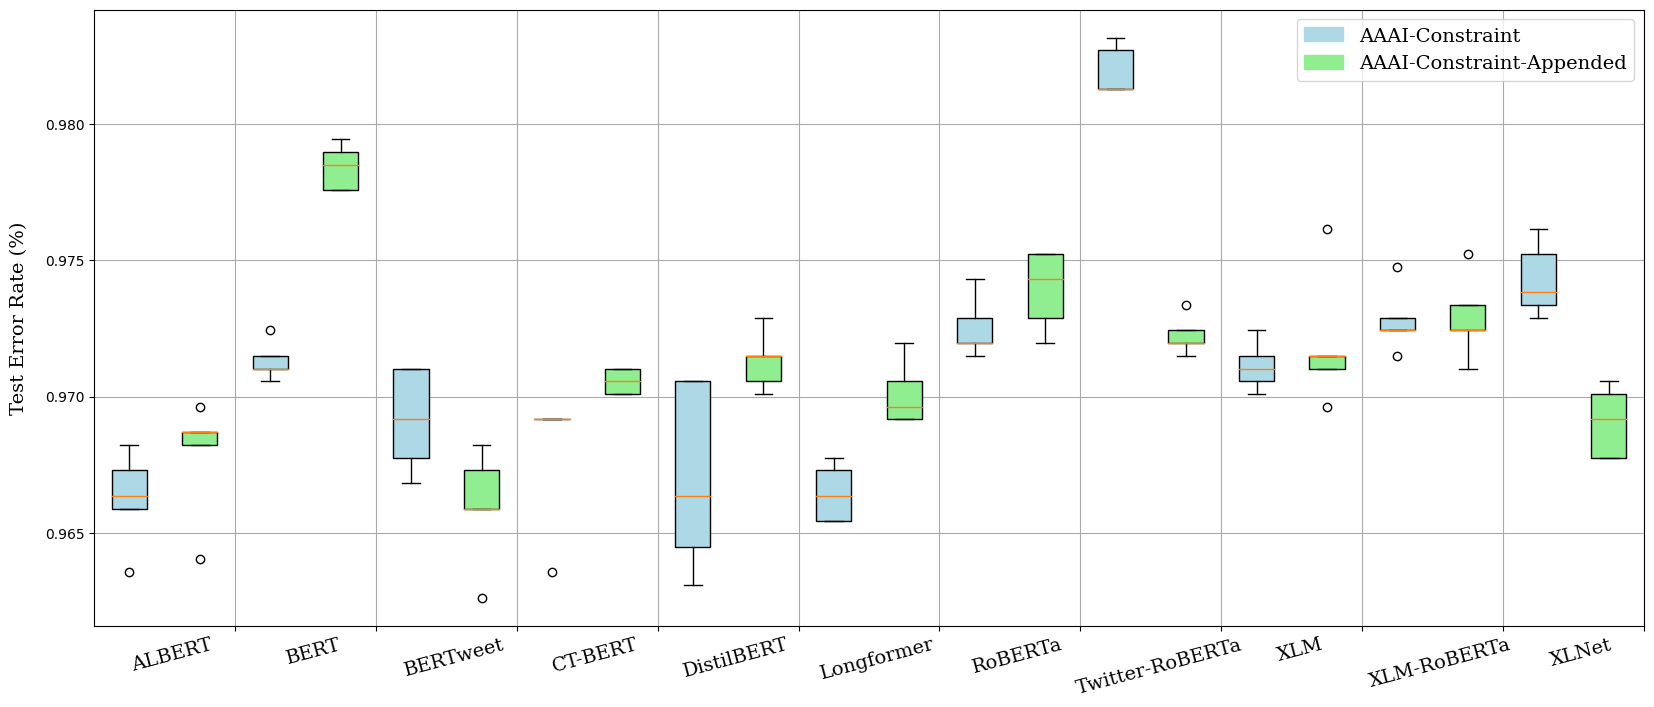

In [4]:
bplot_data = list()

for dataset in datasets:
    results, _ = get_results(dataset, index)
    for model in index:
        scores = list()
        for run in results[model]:
            val_data = run['validation']
            idxs = list(range(jump, len(val_data['batch'])+jump, jump))
            val_metrics = fn_map[metric](val_data, idxs, jump)
            best_val_metric = max(val_metrics)
            test_data = run['testing']
            test_metrics = fn_map[metric](test_data, idxs, jump)
            best_test_metric = 0.
            for val_metric, test_metric in zip(val_metrics, test_metrics):
                if val_metric == best_val_metric:
                    best_test_metric = max(test_metric, best_test_metric)
            scores.append(best_test_metric)
        bplot_data.append(scores)

fig, axs = plt.subplots(1, 1, figsize=(20, 8))
bplot = axs.boxplot(bplot_data, patch_artist=True)
colors = ['lightblue', 'lightgreen']
for i, patch in enumerate(bplot['boxes']):
    patch.set_facecolor(colors[i%2])
fontdict = {'family':'serif', 'color':'black', 'weight':'normal', 'size':14}
axs.set_ylabel('Test Error Rate (%)', fontdict=fontdict, labelpad=12)
plt.xticks(ticks=np.arange(2.5, 23, 2), labels=index, rotation=15, **fontdict)
dx = -45/72; dy = 0/72
offset = mlp.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in axs.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
axs.grid(which='major', color='#AAAAAA', linewidth=0.8)
acc = mlp.patches.Patch(color='lightblue', label='AAAI-Constraint')
acc_a = mlp.patches.Patch(color='lightgreen', label='AAAI-Constraint-Appended')
plt.legend(handles=[acc, acc_a], prop={'family':'serif', 'size': 14})
plt.show()